In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from imutils import contours
import numpy as np
import argparse
import imutils
import pandas as pd
import cv2


In [13]:
imgSize = int(input("Does your model take 28x28(1) images, or are they 64x64(2):"))

img = cv2.imread('archive/helloworldtest.png')
if imgSize == 1:
    labelMap = pd.read_csv("data/emnist-balanced-mapping.txt", 
                            delimiter = ' ', 
                            index_col=0, 
                            header=None, 
                            squeeze=True)
else:
    labelMap = {
            0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9", 10: "A",
            11: "B", 12: "C", 13: "D", 14: "E", 15: "F", 16: "G", 17: "H", 18: "I", 19: "J", 20: "K",
            21: "L", 22: "M", 23: "N", 24: "O", 25: "P", 26: "Q", 27: "R", 28: "S", 29: "T", 30: "U",
            31: "V", 32: "W", 33: "X", 34: "Y", 35: "Z", 36: "a", 37: "b", 38: "c", 39: "d", 40: "e",
            41: "f", 42: "g", 43: "h", 44: "i", 45: "j", 46: "k", 47: "l", 48: "m", 49: "n", 50: "o",
            51: "p", 52: "q", 53: "r", 54: "s", 55: "t", 56: "u", 57: "v", 58: "w", 59: "x", 60: "y",
            61: "z"}

Does your model take 28x28(1) images, or are they 64x64(2):1


In [14]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
chars = []

In [15]:
thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]


cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts, _ = contours.sort_contours(cnts, method="left-to-right")


for c in cnts:
    
    area = cv2.contourArea(c)

    if (area > 100): #and area <3800):
        x,y,w,h = cv2.boundingRect(c)
        ROI = blurred[y:y+h, x:x+w]
        cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 2)
        thresh = cv2.threshold(ROI, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        
        if imgSize ==1:
            (tH, tW) = thresh.shape
            if tW > tH:
                thresh = imutils.resize(thresh, width=28)
            else:
                thresh = imutils.resize(thresh, height=28)

            (tH, tW) = thresh.shape
            dX = int(max(0, 28 - tW) / 2.0)
            dY = int(max(0, 28 - tH) / 2.0)

            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0))

            padded = cv2.resize(padded, (28, 28))
        else:
            (tH, tW) = thresh.shape
            if tW > tH:
                thresh = imutils.resize(thresh, width=64)
            else:
                thresh = imutils.resize(thresh, height=64)

            (tH, tW) = thresh.shape
            dX = int(max(0, 64 - tW) / 2.0)
            dY = int(max(0, 64 - tH) / 2.0)

            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0))

            padded = cv2.resize(padded, (64, 64))
            
            

        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)
        chars.append((padded, (x, y, w, h)))

[INFO] loading handwriting OCR model...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               205056    
_________________________________________________________________
dense_20 (Dens

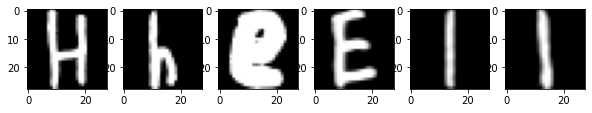

In [16]:
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

fig,axes = plt.subplots(1,6,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(chars[i], cmap=plt.cm.gray)
    
if imgSize == 1:
    print("[INFO] loading handwriting OCR model...")
    model = load_model('my_model.h5')
    model.summary()
else:
    print("[INFO] loading handwriting OCR model...")
    model = load_model('my_model2.h5')
    model.summary()

In [17]:
preds = model.predict(chars)

if imgSize == 1:
    labelDict = {}
    for index, label in enumerate(labelMap):
        labelDict[index] = chr(label)
else:
    labelDict = labelMap


In [18]:
for (pred, (x, y, w, h)) in zip(preds, boxes):

    i = np.argmax(pred)
    prob = pred[i]
    label = labelDict[i]

    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img, label, (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    

    cv2.imshow("Image", img)
    cv2.waitKey(0)

[INFO] H - 100.00%
[INFO] h - 99.95%
[INFO] R - 99.51%
[INFO] E - 100.00%
[INFO] 1 - 64.02%
[INFO] 1 - 61.82%
[INFO] L - 99.98%
[INFO] 0 - 65.38%
[INFO] W - 100.00%
[INFO] L - 99.98%
[INFO] M - 99.94%
[INFO] 0 - 63.90%
[INFO] O - 63.92%
[INFO] W - 99.98%
[INFO] r - 82.05%
[INFO] d - 94.59%
[INFO] 1 - 81.43%
[INFO] 0 - 73.80%
[INFO] d - 55.04%
[INFO] B - 92.13%
[INFO] d - 98.84%
[INFO] L - 99.68%
[INFO] D - 99.99%
